In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from ase import io, Atoms

## Import the ACE potential as an ASE calculator

Within pyace an ase-compatible `PyACECalculator` calcualtor is provided that can perform ACE calculations for any ase-defined structure. The calculator can be simply loaded by providing the path to the fitted ACE potential. as follows:

In [3]:
from pyace import PyACECalculator

In [4]:
calc = PyACECalculator("AlLi-LAMMPS/AlLi.yaml")

The calculator can now be used to calculate the energies and forces for any Al, Li, AlLi structures

Lets generate a bulk fcc Al and bcc Li structure using ase functions

In [14]:
from ase.build import bulk

bulk_Al = bulk("Al")
bulk_Al

Atoms(symbols='Al', pbc=True, cell=[[0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]])

Optionally view the structure

In [15]:
from ase.visualize import view

# view(bulk_Al, viewer="x3d")

To calculate the energy, we need to attach the ACE calculator to this structure

In [16]:
bulk_Al.calc = calc


And now we can calculate the potential energy of this structure

In [17]:
bulk_Al.get_potential_energy()

-3.4830968497729113

Same for Li:

In [18]:
bulk_Li = bulk("Li")
bulk_Li.calc = calc
bulk_Li.get_potential_energy()

-1.7547301583092476

## Lets calculate the EV-curve for both metals

Any number of calculations can now be performed using the fitted potential and ase functions. Lets calculate the equation of state or the 'energy-volume' curves for fcc Al and bcc Li and compare their energies.

In [25]:
def get_EVcurves(bulk_structure, npoints=16):
    # Volume scaling factors
    scaling_factors = np.linspace(0.94, 1.06, npoints)  # 10 scaling factors from 0.94 to 1.06

    # Initialize lists to store volumes and energies
    volumes = []
    energies = []

    # Calculate energy for each scaled volume
    for factor in scaling_factors:
        scaled_structure = bulk_structure.copy()
        scaled_structure.set_cell(bulk_structure.cell * factor, scale_atoms=True)

        scaled_structure.calc = calc

        # Relax the structure
        # opt = BFGS(scaled_structure)
        # opt.run(fmax=0.01)  # Relaxation until forces are below 0.01 eV/Å

        # Calculate energy
        energy = scaled_structure.get_potential_energy() / len(scaled_structure)
        volume = scaled_structure.get_volume() / len(scaled_structure)

        volumes.append(volume)
        energies.append(energy)

    # Convert volumes to per-atom basis if needed
    # volumes_per_atom = np.array(volumes) 
    
    return volumes, energies



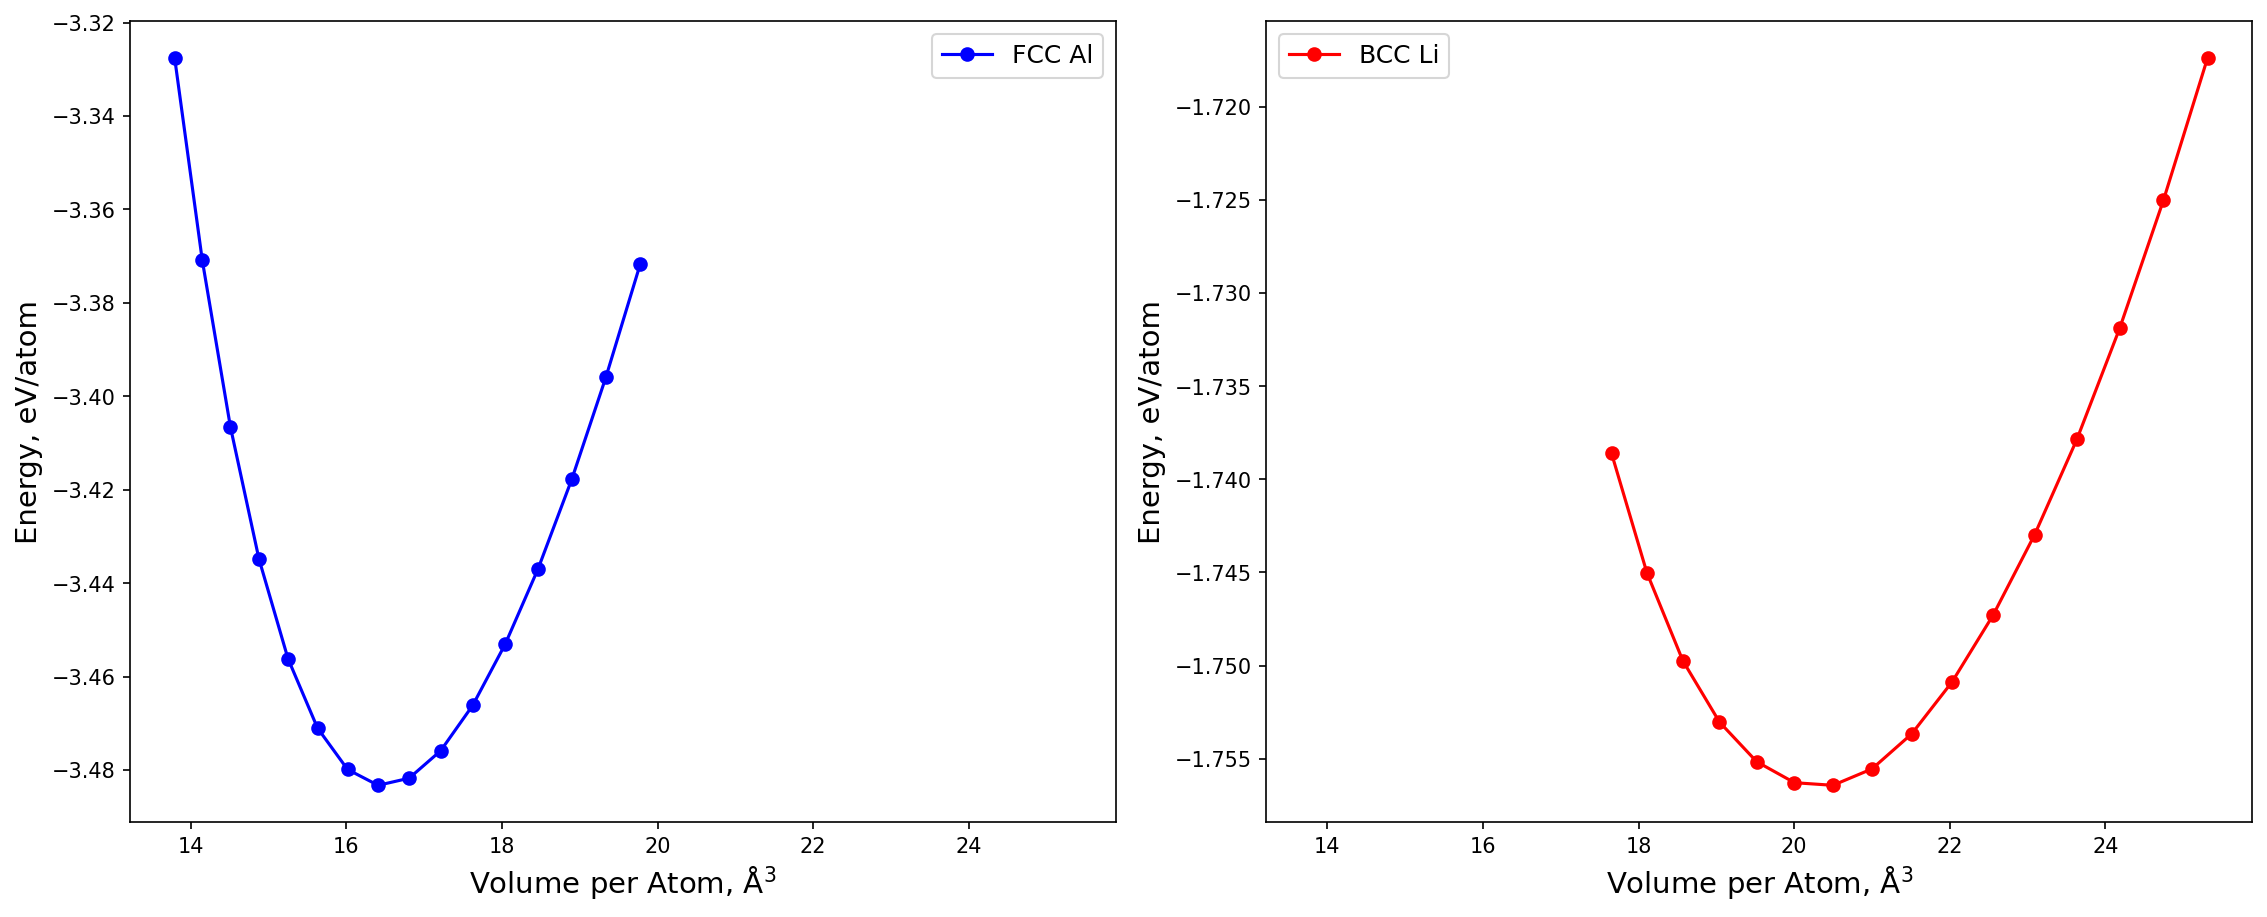

In [39]:
# Plot E-V curve
fontsize=14
labels = ['FCC Al', 'BCC Li']
fig, axs = plt.subplots(1, 2, figsize=(15, 6), layout='constrained', dpi=150, sharex=True)
for i, (ax, lbl) in enumerate(zip(axs.flat, labels)):
    if i == 0:
        al_fcc = bulk("Al", cubic='True')
        volumes_per_atom, energies = get_EVcurves(al_fcc)
        ax.plot(volumes_per_atom, energies, 'bo-', label=lbl)
    
    if i == 1:
        li_bcc = bulk("Li", cubic='True')
        volumes_per_atom, energies = get_EVcurves(li_bcc)
        ax.plot(volumes_per_atom, energies, 'ro-', label=lbl)
    
    ax.set_xlabel('Volume per Atom, Å$^3$', fontsize=fontsize)
    ax.set_ylabel('Energy, eV/atom', fontsize=fontsize)
    ax.legend(prop={"size":fontsize-2})
    

## Fit the energy-volume values to the Birch Murnaghan equation of state

We can further analyze the ground-state fcc structure of Cu by fitting the obtained energies and volumes to the well known [Birch-Murnaghan equation of state](https://journals.aps.org/pr/abstract/10.1103/PhysRev.71.809).

The Birch-Murnaghan equation of state is a widely used model to describe the relationship between energy and volume in crystalline solids. It is given by:

$$
E(V) = E_0 + \frac{9V_0B_0}{16} \left\{ \left[ \left(\frac{V_0}{V}\right)^{2/3} - 1 \right]^3 B_0' + \left[ \left(\frac{V_0}{V}\right)^{2/3} - 1 \right]^2 \left[ 6 - 4 \left(\frac{V_0}{V}\right)^{2/3} \right] \right\}
$$

where:

- $E(V)$ is the energy at volume $V$.
- $E_0$ is the equilibrium energy.
- $V_0$ is the equilibrium volume.
- $B_0$ is the bulk modulus.
- $B_0'$ is the derivative of the bulk modulus with respect to pressure.


Thus when we fit the obtained volumes and energies to the above equation, we can determine many equilibrium properties of the material.

In [40]:
# import numpy as np
from scipy.optimize import curve_fit

# define the BM-equation
def birch_murnaghan(V, E0, V0, B0, B0_prime=4.0):
    """
    Birch-Murnaghan equation of state.
    
    Parameters:
        V (float or array): Volume(s)
        E0 (float): Equilibrium energy
        V0 (float): Equilibrium volume
        B0 (float): Bulk modulus
        B0_prime (float): Pressure derivative of the bulk modulus (default is 4.0)
    
    Returns:
        E (float or array): Energy corresponding to the volume(s)
    """
    r = (V0 / V)**(2.0/3.0)
    return E0 + (9.0 * V0 * B0 / 16.0) * ((r - 1)**3 * B0_prime + (r - 1)**2 * (6.0 - 4.0 * r))

# define a function that uses `scipy.optimzie` to fit the given values to the BM equation and return the eq values
def fit_birch_murnaghan(volumes, energies):
    """
    Fits the Birch-Murnaghan equation of state to the given volumes and energies.
    
    Parameters:
        volumes (array): Array of volumes.
        energies (array): Array of corresponding energies.
    
    Returns:
        V0 (float): Equilibrium volume.
        E0 (float): Equilibrium energy.
        B0 (float): Bulk modulus.
    """
    # Initial guesses for E0, V0, B0
    E0_guess = min(energies)
    V0_guess = volumes[np.argmin(energies)]
    B0_guess = 1.0  # Bulk modulus guess in eV/Å^3

    # Fit the Birch-Murnaghan EOS to the data
    popt, pcov = curve_fit(birch_murnaghan, volumes, energies, p0=[E0_guess, V0_guess, B0_guess])

    # Extract the fitted parameters
    E0, V0, B0 = popt
    return V0, E0, B0



obtain the V and E values for fitting

In [41]:
volumes_per_atom, energies = get_EVcurves(al_fcc, npoints=12)
volumes_per_atom, energies

([13.793949735749994,
  14.279798408367201,
  14.776923532315747,
  15.285454474150072,
  15.805520600424684,
  16.33725127769402,
  16.880775872512586,
  17.436223751434817,
  18.003724281015213,
  18.583406827808236,
  19.17540075836834,
  19.77983543925],
 [-3.3275151631291227,
  -3.384680256223829,
  -3.4277943971106914,
  -3.4577864497196327,
  -3.4757728039079714,
  -3.4830434050587895,
  -3.4810007680916177,
  -3.471045025233899,
  -3.4543991010653174,
  -3.431946147450516,
  -3.4042141930266476,
  -3.3716027225241967])

In [60]:
eV_to_GPa = 160.21766208

V0, E0, B0 = fit_birch_murnaghan(volumes_per_atom, energies)

print(f'Equilibrium volume: {V0:.4f} Å^3; Lattice parameter: {V0**(1/3)*4**(1/3):0.2f} Å')
print(f'Equilibrium energy: {E0:.4f} eV')
print(f'Bulk modulus: {B0*eV_to_GPa:.4f} GPa')


Equilibrium volume: 16.5604 Å^3; Lattice parameter: 4.05 Å
Equilibrium energy: -3.4834 eV
Bulk modulus: 78.7515 GPa


In [66]:
volumes_per_atom, energies = get_EVcurves(li_bcc, npoints=12)
V0, E0, B0 = fit_birch_murnaghan(volumes_per_atom, energies)

print(f'Equilibrium volume: {V0:.4f} Å^3; Lattice parameter: {V0**(1/3)*2**(1/3):0.2f} Å')
print(f'Equilibrium energy: {E0:.4f} eV')
print(f'Bulk modulus: {B0*eV_to_GPa:.4f} GPa')

Equilibrium volume: 20.2429 Å^3; Lattice parameter: 3.43 Å
Equilibrium energy: -1.7568 eV
Bulk modulus: 14.2191 GPa
